In [180]:
# | ITM 618 Course Project
# | Bank Marketing - Term Deposit Subscription
# | Denis Thai | 501176832
# | Selected Models: Decision Tree & Logistic Regression

In [181]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn

In [182]:
# | Import Data
train = pd.read_csv("trainset.csv")
test = pd.read_csv("testset.csv")

In [183]:
# | Debug Prints
print("Train Size: ", train.shape)
print("Test Size: ", test.shape)
print(train.head())

Train Size:  (29271, 15)
Test Size:  (11917, 15)
   age           job   marital            education housing loan    contact  \
0   41   blue-collar  divorced             basic.4y     yes   no  telephone   
1   49  entrepreneur   married    university.degree     yes   no  telephone   
2   49    technician   married             basic.9y      no   no  telephone   
3   41    technician   married  professional.course     yes   no  telephone   
4   45   blue-collar   married             basic.9y     yes   no  telephone   

  month day_of_week  duration  campaign  pdays     poutcome  nr.employed  \
0   may         mon      1575         1    999  nonexistent       5191.0   
1   may         mon      1042         1    999  nonexistent       5191.0   
2   may         mon      1467         1    999  nonexistent       5191.0   
3   may         mon       579         1    999  nonexistent       5191.0   
4   may         mon       461         1    999  nonexistent       5191.0   

  Subscribed  
0   

In [184]:
# | Cleaning Data
categorical_cols = [
    "job",
    "marital",
    "education",
    "housing",
    "loan",
    "contact",
    "month",
    "day_of_week",
    "poutcome"
]

numeric_cols = [
    "age",
    "duration",
    "campaign",
    "pdays",
    "nr.employed",
]

# | Cleaning Unknowns.
for col in categorical_cols:
  mode_val = train[col].mode()[0]
  train.loc[train[col] == "unknown", col] = mode_val
  test.loc[train[col] == "unknown", col] = mode_val

# | Separate features / target using some binary encoding
X = train.drop("Subscribed", axis = 1)
y = train["Subscribed"].map({"no": 0, "yes": 1})

X_test_final = test.drop("Subscribed", axis = 1)
y_test_final = test["Subscribed"].map({"no": 0, "yes": 1})

# | ColumnTransformer using sklearn, One Hot Encoding
preprocessor = sklearn.compose.ColumnTransformer(
    transformers=[
        ("num","passthrough", numeric_cols),
        ("cat", sklearn.preprocessing.OneHotEncoder(handle_unknown="ignore"), categorical_cols)
    ]
)

In [185]:
# | Training Data

X_train, x_valid, y_train, y_valid = sklearn.model_selection.train_test_split(
    X, y,
    test_size = 0.2,
    random_state = 42,
    stratify = y
)

# Debug Prints
print("\nSplit Sizes:")
print("Train: ", X_train.shape)
print("Valid: ", x_valid.shape)
print("Test: ", X_test_final.shape)



Split Sizes:
Train:  (23416, 14)
Valid:  (5855, 14)
Test:  (11917, 14)


In [186]:
# | Modelling (Decision Tree)

dt_model = sklearn.pipeline.Pipeline(
    [
        ("preprocess", preprocessor),
        ("model", sklearn.tree.DecisionTreeClassifier(
            max_depth = 6,
            random_state = 42
        ))
    ]
)

# | Modelling (Logistic Regression)
lr_model = sklearn.pipeline.Pipeline(
    [
      ("preprocess", preprocessor),
      ("model", sklearn.linear_model.LogisticRegression(
          max_iter = 5000,
          random_state = 42
      ))
    ]
)

In [187]:
# | Training Models

dt_model.fit(X_train, y_train)
lr_model.fit(X_train, y_train)

# | Evaluations of models (Getting accuracy/precision + more.)

def evaluate(model_name, model, X_tr, y_tr, X_v, y_v, X_te, y_te):
  for split_label , X_split, y_split in [
    ("Train", X_tr, y_tr),
    ("Valid", X_v, y_v),
    ("Test", X_te, y_te),
  ]:

    y_pred = model.predict(X_split)
    y_prob = model.predict_proba(X_split)[:,1]

    accuracy = sklearn.metrics.accuracy_score(y_split, y_pred)
    precision = sklearn.metrics.precision_score(y_split, y_pred)
    recall = sklearn.metrics.recall_score(y_split, y_pred)
    f1score = sklearn.metrics.f1_score(y_split, y_pred)
    rocauc = sklearn.metrics.roc_auc_score(y_split, y_pred)
    cmatrix = sklearn.metrics.confusion_matrix(y_split, y_pred)

    # | Print for future debugging
    print(f"Results for {model_name}")
    print("Accuracy: ", accuracy)
    print("Precision: ", precision)
    print("Recall: ", recall)
    print("F1 Score: ", f1score)
    print("ROC AUC: ", rocauc)
    print("Confusion Matrix: ", "\n",  cmatrix)
    print("==========================") # Split the printing to easier read.

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


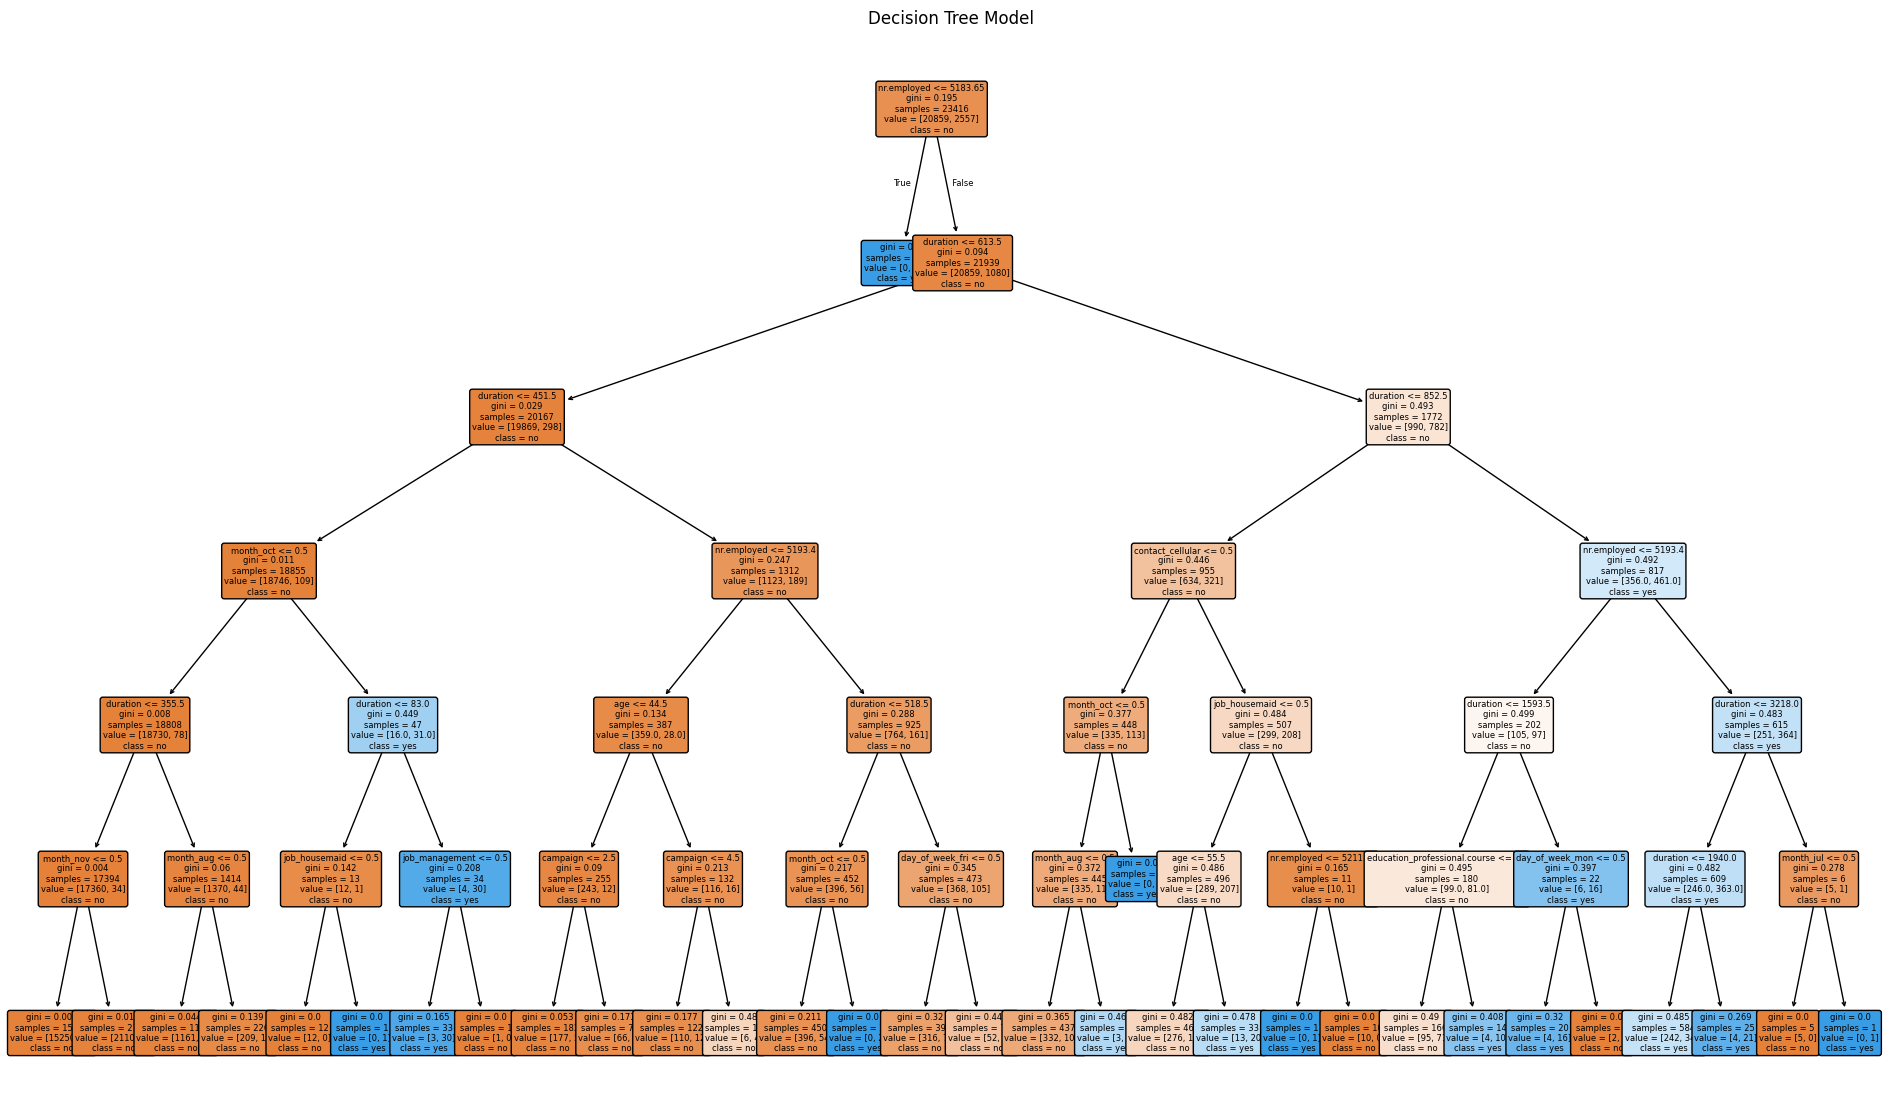

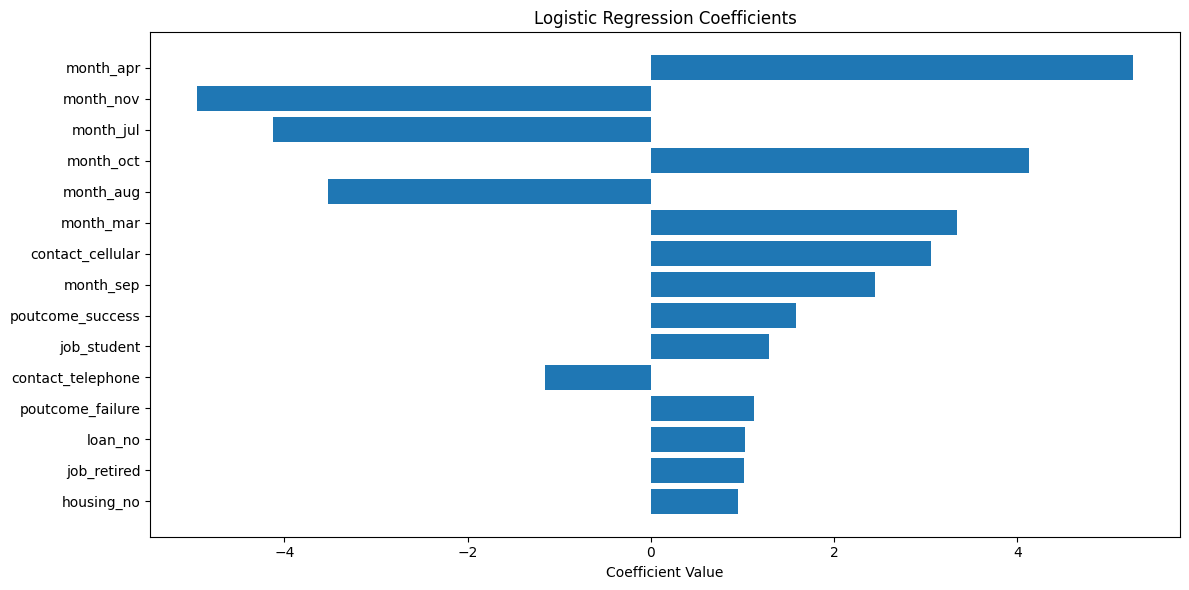

In [194]:
# | Decision Tree Graphic

oneh = dt_model.named_steps["preprocess"].named_transformers_["cat"]
cat_features = oneh.get_feature_names_out(categorical_cols)
all_features = list(numeric_cols) + list(cat_features)

plt.figure(figsize=(24, 14))
sklearn.tree.plot_tree(
    dt_model.named_steps["model"],
    feature_names = all_features,
    class_names = ["no", "yes"],
    filled = True,
    rounded = True,
    fontsize = 6
)

plt.title("Decision Tree Model")
plt.show()

# | Linear Regression Graphic

ohe = lr_model.named_steps["preprocess"].named_transformers_["cat"]
cat_features = ohe.get_feature_names_out(categorical_cols)
all_features = numeric_cols + list(cat_features)

log_reg = lr_model.named_steps["model"]
coefs = log_reg.coef_[0]

top_idx = np.argsort(np.abs(coefs))[-15:]
top_features = [all_features[i] for i in top_idx]
top_values = coefs[top_idx]

plt.figure(figsize=(12,6))
plt.barh(top_features, top_values)
plt.xlabel("Coefficient Value")
plt.title("Logistic Regression Coefficients")
plt.tight_layout()
plt.show()


In [189]:
# | Launching Evaluations using the function.
evaluate("Decision Tree",  dt_model, X_train, y_train, x_valid, y_valid, X_test_final, y_test_final)
evaluate("Logistic Regression",  lr_model, X_train, y_train, x_valid, y_valid, X_test_final, y_test_final)

Results for Decision Tree
Accuracy:  0.9615220362145541
Precision:  0.8760217983651226
Recall:  0.7543996871333594
F1 Score:  0.8106745114519857
ROC AUC:  0.8706559056981337
Confusion Matrix:  
 [[20586   273]
 [  628  1929]]
Results for Decision Tree
Accuracy:  0.9608881298035867
Precision:  0.8782287822878229
Recall:  0.7449139280125195
F1 Score:  0.8060965283657917
ROC AUC:  0.8661302768896955
Confusion Matrix:  
 [[5150   66]
 [ 163  476]]
Results for Decision Tree
Accuracy:  0.142737266090459
Precision:  0.12384219554030874
Recall:  1.0
F1 Score:  0.22039072039072038
ROC AUC:  0.512269645755753
Confusion Matrix:  
 [[  257 10216]
 [    0  1444]]
Results for Logistic Regression
Accuracy:  0.9508455756747523
Precision:  0.8707805907172996
Recall:  0.6456785295267892
F1 Score:  0.7415225690545699
ROC AUC:  0.8169665000095713
Confusion Matrix:  
 [[20614   245]
 [  906  1651]]
Results for Logistic Regression
Accuracy:  0.9492741246797609
Precision:  0.8701298701298701
Recall:  0.62910

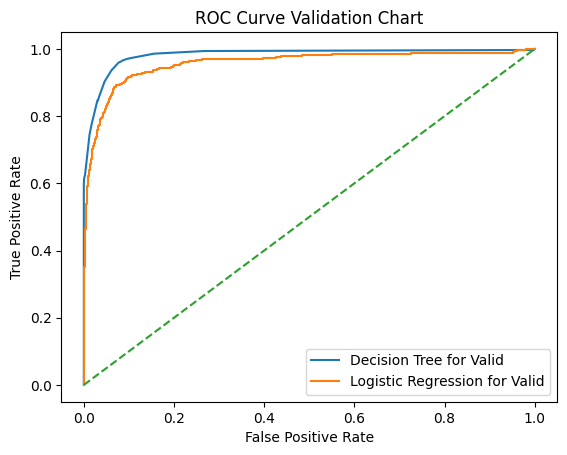

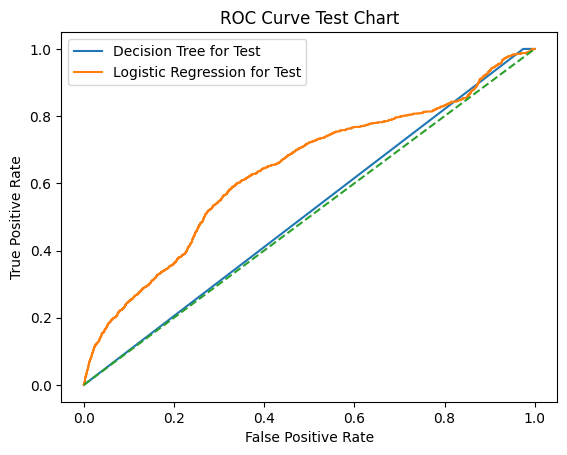

In [190]:
# | ROC Curve Plots
def plot_roc(model, X_split, y_split, label):
  y_prob = model.predict_proba(X_split)[:, 1]
  fpr, tpr, _ = sklearn.metrics.roc_curve(y_split, y_prob)
  plt.plot(fpr, tpr, label = label)

# | Validation
plt.figure()
plot_roc(dt_model, x_valid, y_valid, "Decision Tree for Valid")
plot_roc(lr_model, x_valid, y_valid, "Logistic Regression for Valid")
plt.plot([0,1],[0,1], "--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Validation Chart")
plt.legend()
plt.show()

# | Test Set
plt.figure()
plot_roc(dt_model, X_test_final, y_test_final, "Decision Tree for Test")
plot_roc(lr_model, X_test_final, y_test_final, "Logistic Regression for Test")
plt.plot([0,1],[0,1], "--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Test Chart")
plt.legend()
plt.show()
